In [2]:
import math
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.validation import make_valid
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import geopandas as gpd
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import utm #pip install utm
from pyproj import CRS
from shapely.geometry import Polygon, Point, LineString
from math import atan2, degrees

In [3]:
# Function to convert Footprint2D string to list of points
def footprint_to_polygon(footprint_str):
    points = [tuple(list(map(float, point.split(',')))[::-1]) for point in footprint_str.split()]
    return Polygon(points)
def convert_footprint_to_points(footprint):
    points = footprint.split('_')
    point_tuples = [tuple(map(float, point.split('/'))) for point in points]
    return point_tuples
def convert_polygon_to_tuples(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    return coords

In [20]:
# 加载数据
raw = pd.read_csv('SF.csv')

# 创建需要的数据子集
data4shading = raw[['ID', 'Footprint2D', 'Height', 'WWR_surfaces', 'lat', 'lon']].copy()

# 使用 .loc[] 来赋值，避免 SettingWithCopyWarning
data4shading.loc[:, 'FootprintPoints'] = data4shading['Footprint2D'].apply(convert_footprint_to_points)
data4shading.loc[:, 'FootprintPointsStr'] = data4shading['FootprintPoints'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)
data4shading.loc[:, 'geometry'] = data4shading['FootprintPointsStr'].apply(footprint_to_polygon)

# 使用GeoDataFrame处理地理数据
gdf = gpd.GeoDataFrame(data4shading, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
utm_crs = gdf.estimate_utm_crs()
print(utm_crs)
gdf = gdf.to_crs(utm_crs)
gdf['geometry_points'] = gdf.geometry.centroid

# 提取经纬度
gdf['lat_utm'] = gdf['geometry_points'].y
gdf['lon_utm'] = gdf['geometry_points'].x
gdf['coordinates'] = gdf['geometry'].apply(convert_polygon_to_tuples)

# 显示前两行数据
gdf.head(2)

EPSG:32610


,ID,Footprint2D,Height,WWR_surfaces,lat,lon,FootprintPoints,FootprintPointsStr,geometry,geometry_points,lat_utm,lon_utm,coordinates
0,90032007980815,37.799329/-122.447322_37.799362/-122.447029_37...,61.992934,.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15,37.799148,-122.447165,"[(37.799329, -122.447322), (37.799362, -122.44...","37.799329,-122.447322 37.799362,-122.447029 37...","POLYGON ((548655.767 4183694.366, 548681.54 41...",POINT (548669.716 4183674.384),4.183674e+06,548669.715686,"[(548655.7668084321, 4183694.3661477994), (548..."
1,90032007980816,37.79428/-122.437969_37.794291/-122.437867_37....,111.365812,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.794191,-122.437547,"[(37.79428, -122.437969), (37.794291, -122.437...","37.79428,-122.437969 37.794291,-122.437867 37....","POLYGON ((549482.545 4183139.091, 549491.518 4...",POINT (549519.793 4183129.454),4.183129e+06,549519.792754,"[(549482.5453899564, 4183139.0911058243), (549..."


(1, 13)
Grid cell (0, 0) contains 1 buildings
1
1
[552964.63906617 552954.14167014 552945.63541869 552945.37269802
 552939.52434792 552930.2517673  552944.34079359 552928.41922479
 552906.53264875 552902.50804379 552883.81202051 552923.79089198
 552964.63906617] [4182601.77301472 4182591.05388099 4182599.32073799 4182599.09713995
 4182604.82914984 4182595.33841959 4182581.55973698 4182565.36899996
 4182586.75343612 4182582.7332218  4182600.92054794 4182641.56479276
 4182601.77301472]


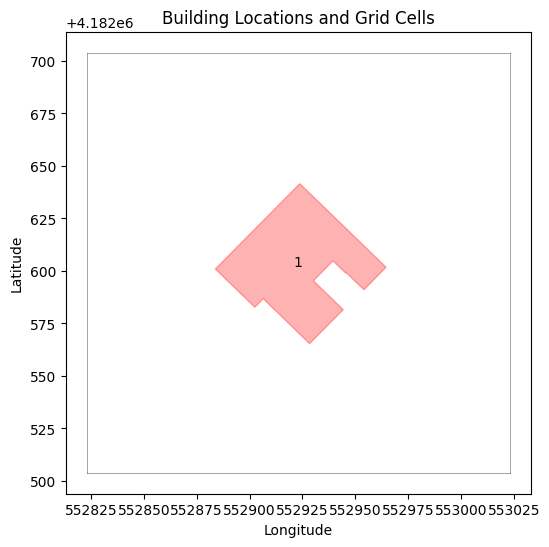

1


In [58]:

test_data_df = pd.read_csv('test_case.csv')

test_case = '1-2'
sample_lat = test_data_df[test_data_df['index']==test_case]['sample_lat'].values[0]
sample_lon = test_data_df[test_data_df['index']==test_case]['sample_lon'].values[0]
threshold = test_data_df[test_data_df['index']==test_case]['radius'].values[0]

# Filter the DataFrame
SF_filtered = gdf[(gdf['lat_utm'] > (sample_lat - threshold)) & (gdf['lat_utm'] < (sample_lat + threshold)) &
                 (gdf['lon_utm'] > (sample_lon - threshold)) & (gdf['lon_utm'] < (sample_lon + threshold))]
test = SF_filtered
print(test.shape)

# 使用 .loc 方法来安全地添加新列
test.loc[:, 'FootprintPointsStr'] = test['coordinates'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)

# 保存到 CSV，确保没有索引
test[['ID', 'Height', 'coordinates']].to_csv('ORNL563_forGH.csv', index=False)

xxx_xy=[]
xxx=[]
xxx_gaodu=[]
for index, row in test.iterrows():
    # border_points = row['formatted_geometry']
    # height = row['hgt_median_m']
    border_points = row['coordinates']
    height = row['Height']
    
    y, x = zip(*border_points)
    x=list(x)
    y=list(y)
    arrayx = np.array(x)
    arrayy = np.array(y)
    z=np.zeros(len(list(x)))
    z_height=[height]*(len(list(x)))
    zuobiao_xy=zip(list(arrayx),list(arrayy))
    zuobiao=zip(list(arrayx),list(arrayy),list(z))
    zuobiao_gaodu=zip(list(arrayx),list(arrayy),list(z_height))
    xxx_xy.append(list(zuobiao_xy))
    xxx.append(list(zuobiao))
    xxx_gaodu.append(list(zuobiao_gaodu))    
#define analysis area
num_cell = 1
buildings_analysis_xy=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis_height=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
bounds = [[0]*num_cell for _ in range(num_cell)]
bounds
offset = 100
lat_max = test['lat_utm'].max()+offset
lat_min = test['lat_utm'].min()-offset
lon_max = test['lon_utm'].max()+offset
lon_min = test['lon_utm'].min()-offset

lat_step = (lat_max - lat_min) / num_cell
lon_step = (lon_max - lon_min) / num_cell
num_building = 0
for i in range(0,num_cell,1):
    for j in range(0,num_cell,1):
        bounds[i][j] = [lat_min + j * lat_step, lon_min + i * lon_step, lat_min + (j + 1) * lat_step, lon_min + (i + 1) * lon_step]
        for t in range(len(xxx)):
            #filter the buildings
            center=np.mean(np.array(xxx[t]),axis=0)
            if center[0]> bounds[i][j][0] and center[0] <=  bounds[i][j][2] and center[1] >  bounds[i][j][1] and center[1] <=  bounds[i][j][3]:
                buildings_analysis_xy[i][j].append(xxx_xy[t])
                buildings_analysis[i][j].append(xxx[t])
                buildings_analysis_height[i][j].append(xxx_gaodu[t])
                num_building +=1
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            print(f"Grid cell ({i}, {j}) contains {len(buildings_analysis[i][j])} buildings")
        # else:
        #     print(f"Grid cell ({i}, {j}) NOT contains buildings")
print(len(xxx))
print(num_building)
# Plotting the grid and buildings
fig, ax = plt.subplots(figsize=(6,6))

# Plot the grid
for i in range(num_cell + 1):
    plt.plot([lon_min, lon_max], [lat_min + i * lat_step, lat_min + i * lat_step], color='black',linewidth = 0.5, alpha = 0.5)
for j in range(num_cell + 1):
    plt.plot([lon_min + j * lon_step, lon_min + j * lon_step], [lat_min, lat_max], color='black',linewidth = 0.5, alpha = 0.5)

# Plot the buildings with polylines
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # Define some colors for different buildings
for t, building in enumerate(xxx_xy):
    building = np.array(building)
    # plt.plot(building[:, 1], building[:, 0], marker='o', linestyle='-', color=colors[t % len(colors)], label=f'Building {t}')
    plt.fill(building[:, 1], building[:, 0], color=colors[t % len(colors)], alpha=0.3)  # Fill the polygon for better visualization
    print(building[:, 1], building[:, 0])

numbuilding = 0
# Annotate grid cells with building count
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            numbuilding += len(buildings_analysis[i][j])
            cell_center_lat = (bounds[i][j][0] + bounds[i][j][2]) / 2
            cell_center_lon = (bounds[i][j][1] + bounds[i][j][3]) / 2
            ax.text(cell_center_lon, cell_center_lat, f"{len(buildings_analysis[i][j])}", 
                    color='black', fontsize=10, ha='center', va='center')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
title = 'Building Locations and Grid Cells'
plt.title(title)
plt.show()
# plt.savefig(f'{title}.png',bbox_inches='tight',transparent=True)
print(numbuilding)

In [59]:
As_list_pd = pd.read_csv('solar azimuth angle.csv')
As_list = As_list_pd['Solar\nAzimuth:'].to_list()
hs_list = As_list_pd['Solar\nElevation:'].to_list()
def calculate_geometry_metrics(coords, geom_type='Polygon'):
    if geom_type == 'Polygon':
        geom = Polygon(coords)
        centroid = geom.centroid
        area = geom.area
        return area, (centroid.x, centroid.y)
    elif geom_type == 'LineString':
        geom = LineString(coords)
        length = geom.length
        midpoint_x = (coords[0][0] + coords[1][0]) / 2
        midpoint_y = (coords[0][1] + coords[1][1]) / 2
        return length, (midpoint_x, midpoint_y)
def calculate_azimuth(point1, point2):
    dx = point2[0] - point1[0] # x is longtitude, this calculates diff in long
    dy = point2[1] - point1[1] # latitude
    azimuth = degrees(atan2(dy, dx))
    azimuth = (azimuth-90)% 360  # Ensure the angle is between 0 and 360 degrees
    return azimuth

def calPlaneFrom3Points(Point1,Point2,Point3):
    xo1=Point1[0]
    yo1=Point1[1]
    zo1=Point1[2]
    xo2=Point2[0]
    yo2=Point2[1]
    zo2=Point2[2]
    xo3=Point3[0]
    yo3=Point3[1]
    zo3=Point3[2]
    a=(yo2-yo1)*(zo3-zo1)-(yo3-yo1)*(zo2-zo1)
    b=(zo2-zo1)*(xo3-xo1)-(zo3-zo1)*(xo2-xo1)
    c=(xo2-xo1)*(yo3-yo1)-(xo3-xo1)*(yo2-yo1)
    d=-(a*xo1+b*yo1+c*zo1)
    return a,b,c,d

#求线面交点定义的函数
def calCoordinateFromLineAndPlane(P1,F1,PlaneParams):
    a=np.array(PlaneParams[0])
    b=np.array(PlaneParams[1])
    c=np.array(PlaneParams[2])
    d=np.array(PlaneParams[3])
    x1=np.array(P1[0])
    y1=np.array(P1[1])
    z1=np.array(P1[2])
    m=np.array(F1[0])
    n=np.array(F1[1])
    p=np.array(F1[2])
    t=(-a*x1-b*y1-c*z1-d)/(a*m+b*n+c*p)
    x=m*t+x1
    y=n*t+y1
    z=p*t+z1
    return x,y,z

In [60]:
buildings_analyzed = 0
unique_building_id = 0
results = {}
building_loc_metadata = {}
building_loc = []
for r in range(0,num_cell,1):
    for w in range(0,num_cell,1):
        for q in tqdm(range(len(buildings_analysis[r][w]))):
            cell_key = f'cell_{r}_{w}'
            building_key = f'building_{unique_building_id}'
            cell_key_loc = f'cell_{r}_{w}'
            building_key_loc = f'building_{unique_building_id}'
            if cell_key not in building_loc_metadata:
                building_loc_metadata[cell_key] = {}
            if building_key not in building_loc_metadata[cell_key]:
                building_loc_metadata[cell_key][building_key] = {
                    'roof_loc': None,
                    'facade_loc': {},
                    'facade_azimuth': {}
                }


            # 从数组中获取数据并转换为 NumPy 数组
            building_target = np.array(buildings_analysis[r][w][q])
            building_target_xy = np.array(buildings_analysis_xy[r][w][q])
            building_target_dingmian = np.array(buildings_analysis_height[r][w][q])
            
            # 打印原始数据
            # print("Original building_target_xy:", building_target_xy)
            
            # 交换第一列和第二列的数据
            building_target[:, [0, 1]] = building_target[:, [1, 0]]
            building_target_xy[:, [0, 1]] = building_target_xy[:, [1, 0]]
            building_target_dingmian[:, [0, 1]] = building_target_dingmian[:, [1, 0]]
            
            # 打印修改后的数据
            # print("Modified building_target_xy:", building_target_xy)

            # building_target=buildings_analysis[r][w][q]
            # building_target_xy=buildings_analysis_xy[r][w][q]
            # print(building_target_xy)
            # building_target_dingmian=buildings_analysis_height[r][w][q] # 建筑三维坐标数据组

            # building_target[:, [0, 1]] = building_target[:, [1, 0]]
            # building_target_xy[:, [0, 1]] = building_target_xy[:, [1, 0]]
            # building_target_dingmian[:, [0, 1]] = building_target_dingmian[:, [1, 0]]
            # print(building_target_xy)
            
            original_roof_area, roof_centroid = calculate_geometry_metrics(building_target_xy, geom_type='Polygon')
            original_facade_areas = []
            facade_azimuths = []
            facade_loc = []
            building_loc.append(building_target_xy)
            building_loc_metadata[cell_key][building_key]['roof_loc'] = building_target_xy
            for u in range(len(building_target) - 1):
                
                segment_length, segment_midpoint = calculate_geometry_metrics([building_target[u], building_target[u + 1]], geom_type='LineString')
                height = building_target_dingmian[u][2]  # Assuming the height is the z-coordinate
                facade_area = segment_length * height
                original_facade_areas.append(facade_area)
                azimuth = calculate_azimuth(building_target[u], building_target[u + 1])
                facade_azimuths.append(azimuth)
                facade_loc.append(segment_midpoint)
            building_loc_metadata[cell_key][building_key]['facade_loc'] = facade_loc
            building_loc_metadata[cell_key][building_key]['facade_azimuth'] = facade_azimuths

            # Calculate cos values for BASE coordinates
            cos_=[]
            for l in range(0,len(building_target)-1,1):
                f_l=np.array(building_target_xy[l+1])-np.array(building_target_xy[l])
                xx=np.array([1,0])
                l_xx=np.sqrt(xx.dot(xx))
                l_f_l=np.sqrt(f_l.dot(f_l))
                dian=xx.dot(f_l)
                cos_.append(dian/(l_xx*l_f_l))

            # Calculate center and radius of bounding circle
            #求建筑基低中心坐标，即最小外接矩形中心点坐标,1是目标建筑
            p1=Polygon(building_target_xy)     
            xmin=p1.bounds[0]
            ymin=p1.bounds[1]
            xmax=p1.bounds[2]
            ymax=p1.bounds[3]
            cx1=(xmin+xmax)/2
            cy1=(ymin+ymax)/2
            pc1=Point(cx1,cy1)
            
            #求目标建筑最小包围圆的半径，即基底中心到各顶点距离的最大值
            round_r = max(pc1.distance(Point(coord)) for coord in building_target_xy)
            
            # print("目标建筑最小包围圆的半径",round_r)
            # print("目标建筑是",r,w,"格子里的第",q+1,"个建筑")
            
            lat=38
            p=math.pi

            for k in range (164,165):
                for i in range(24):
                    hs = hs_list[i] 
                    if hs<=0:
                        continue
                    As = As_list[i]

                    sun=np.array([-math.sin(As*p/180)*math.cos(hs*p/180),-math.cos(As*p/180)*math.cos(hs*p/180),-math.sin(hs*p/180)])

                    print(sun)


                    sec_f=Polygon()
                    s_mian=[Polygon()]*(len(building_target)-1)
                    s_mian_shu=[0]*(len(building_target)-1)


                    #筛选目标建筑向阳面
                    u_box=[]
                    for u in range(0,len(building_target)-1,1):
                        building_v1=building_target[u]
                        building_v2=building_target[u+1]
                        building_v3=building_target_dingmian[u]
                        # print(building_v3)                       
                        # print(building_v2)
                        # print(building_v1)

                        v31=np.array(building_v3)-np.array(building_v1)
                        v21=np.array(building_v2)-np.array(building_v1)

                        normal=np.cross(v31,v21)
                        # 分别计算两个向量的模：
                        # l_normal=np.sqrt(normal.dot(normal))
                        # l_sun=np.sqrt(sun.dot(sun))

                        # 计算两个向量的点积
                        # dian=normal.dot(sun)

                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                        # cos=dian/(l_normal*l_sun)
                        # 取前两个元素形成新的二维向量
                        normal_2d = normal[:2]
                        # print(normal)
                        sun_2d = sun[:2]
                        
                        # 计算两个二维向量的模
                        l_normal_2d = np.sqrt(normal_2d.dot(normal_2d))
                        l_sun_2d = np.sqrt(sun_2d.dot(sun_2d))
                        
                        # 计算两个向量的点积
                        dian_2d = normal_2d.dot(sun_2d)
                        
                        # 计算夹角的cos值
                        cos_2d = dian_2d / (l_normal_2d * l_sun_2d)
                        # print(cos_2d)
                        
                        if -0.01<= abs(cos_2d - 0) <= 0.01:
                            cos_2d = 0
                        if -1 < cos_2d <= 0: 
                            u_box.append(u)
                            
                    #筛选目标建筑会被自己遮挡的向阳面 （所有向阳面）
                    u_mian=[]
                    for e in range(0,len(u_box),1):
                        u=u_box[e]
                        if xmin<building_target[u][0]<xmax and  xmin<building_target[u+1][0]<xmax and ymin<building_target[u][1]<ymax and  ymin<building_target[u+1][1]<ymax:
                            u_mian.append(u)

                    
                    #求自遮挡（其他向阳面及顶面对mm面造成的遮挡）
                    for h in range(0,len(u_mian),1):    
                        mm=u_mian[h]
                        for e in range(0,len(u_box),1):
                            u=u_box[e]            
                            if u!=mm:          
                                PlaneParams=calPlaneFrom3Points(building_target[mm],building_target[mm+1],building_target_dingmian[mm+1])
                                #当受到自遮挡的目标面是与x轴平行的面,y一样的
                                if building_target[mm][0]!=building_target[mm+1][0]:
                                    polygon_mian=Polygon([[building_target[mm][0],building_target[mm][2]],[building_target[mm+1][0],building_target[mm+1][2]],[building_target_dingmian[mm+1][0],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][0],building_target_dingmian[mm][2]]])
                                    xyz1=calCoordinateFromLineAndPlane(building_target[u],sun,PlaneParams)
                                    xyz1_arr=np.asarray(xyz1)
                                    point1=(xyz1_arr[0],xyz1_arr[2])
                                    xyz2=calCoordinateFromLineAndPlane(building_target[u+1],sun,PlaneParams)
                                    xyz2_arr=np.asarray(xyz2)
                                    point2=(xyz2_arr[0],xyz2_arr[2])
                                    xyz3=calCoordinateFromLineAndPlane(building_target_dingmian[u+1],sun,PlaneParams)
                                    xyz3_arr=np.asarray(xyz3)
                                    point3=(xyz3_arr[0],xyz3_arr[2])                        
                                    xyz4=calCoordinateFromLineAndPlane(building_target_dingmian[u],sun,PlaneParams)
                                    xyz4_arr=np.asarray(xyz4)
                                    point4=(xyz4_arr[0],xyz4_arr[2])
                                    targetbd=Polygon([point1,point2,point3,point4])

                                    s_mian[mm]=s_mian[mm].union(targetbd)
                                    s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                                    s_mian_shu[mm]=s_mian[mm].area
                                    # print(s_mian_shu)


                                #当受到自遮挡的目标面是与y轴平行的面，x一样的
                                if building_target[mm][0]==building_target[mm+1][0]:
                                    polygon_mian=Polygon([[building_target[mm][1],building_target[mm][2]],[building_target[mm+1][1],building_target[mm+1][2]],[building_target_dingmian[mm+1][1],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][1],building_target_dingmian[mm][2]]])            
                                    xyz1=calCoordinateFromLineAndPlane(building_target[u],sun,PlaneParams)
                                    xyz1_arr=np.asarray(xyz1)
                                    point1=(xyz1_arr[1],xyz1_arr[2])
                                    xyz2=calCoordinateFromLineAndPlane(building_target[u+1],sun,PlaneParams)
                                    xyz2_arr=np.asarray(xyz2)
                                    point2=(xyz2_arr[1],xyz2_arr[2])
                                    xyz3=calCoordinateFromLineAndPlane(building_target_dingmian[u+1],sun,PlaneParams)
                                    xyz3_arr=np.asarray(xyz3)
                                    point3=(xyz3_arr[1],xyz3_arr[2])                        
                                    xyz4=calCoordinateFromLineAndPlane(building_target_dingmian[u],sun,PlaneParams)
                                    xyz4_arr=np.asarray(xyz4)
                                    point4=(xyz4_arr[1],xyz4_arr[2])
                                    targetbd=Polygon([point1,point2,point3,point4])

                                    s_mian[mm]=s_mian[mm].union(targetbd)
                                    s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                                    s_mian_shu[mm]=s_mian[mm].area
                                    # /abs(cos_[mm]) 

                        #计算顶面的遮挡面积
                        point_ding=[]
                        PlaneParams=calPlaneFrom3Points(building_target[mm],building_target[mm+1],building_target_dingmian[mm+1])

                        if building_target[mm][0]!=building_target[mm+1][0]:

                            polygon_mian=Polygon([[building_target[mm][0],building_target[mm][2]],[building_target[mm+1][0],building_target[mm+1][2]],[building_target_dingmian[mm+1][0],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][0],building_target_dingmian[mm][2]]])
                            for s in range(0,len(building_target_dingmian)-1,1):
                                xyz=calCoordinateFromLineAndPlane(building_target_dingmian[s],sun,PlaneParams)
                                xyz_arr=np.asarray(xyz)
                                point=(xyz_arr[0],xyz_arr[2])
                                point_ding.append(point)
                            targetbd_ding=Polygon(point_ding)
                            targetbd_ding=make_valid(targetbd_ding)
                            s_mian[mm]=s_mian[mm].union(targetbd_ding)
                            s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                            s_mian_shu[mm]=s_mian[mm].area/abs(cos_[mm])

 
                        if building_target[mm][0]==building_target[mm+1][0]:
                            polygon_mian=Polygon([[building_target[mm][1],building_target[mm][2]],[building_target[mm+1][1],building_target[mm+1][2]],[building_target_dingmian[mm+1][1],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][1],building_target_dingmian[mm][2]]])            
                            for s in range(0,len(building_target)-1,1):
                                xyz=calCoordinateFromLineAndPlane(building_target_dingmian[s],sun,PlaneParams)
                                xyz_arr=np.asarray(xyz)
                                point=(xyz_arr[1],xyz_arr[2])
                                point_ding.append(point)
                            targetbd_ding=Polygon(point_ding)
                            targetbd_ding=make_valid(targetbd_ding)

                            s_mian[mm]=s_mian[mm].union(targetbd_ding)
                            s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                            s_mian_shu[mm]=s_mian[mm].area/abs(cos_[mm])       
            
            
                    #一栋一栋求邻域建筑的阴影
                    for n in range(len(buildings_analysis[r][w])):
                        if n==q:
                            continue
                        if n!=q:
                            building_near_xy=buildings_analysis_xy[r][w][n]
                            building_near=buildings_analysis[r][w][n]
                            building_near_dingmian=buildings_analysis_height[r][w][n]

                        cxn=(Polygon(building_near_xy).bounds[0]+Polygon(building_near_xy).bounds[2])/2
                        cyn=(Polygon(building_near_xy).bounds[1]+Polygon(building_near_xy).bounds[3])/2
                        pcn=Point(cxn,cyn)
                        # print(n,"第n个建筑基底中心坐标",cxn,cyn)
                        #求两两建筑修正过的欧几里得距离
                        dis_bds=pc1.distance(pcn)-round_r
                        # print("两建筑距离",dis_bds)


                        #判断距离是否小于R
                        Hmax=building_near_dingmian[0][2]/math.tan(hs*p/180)
                        # print("这是最小建筑距离Hmax:",Hmax)
                        if dis_bds<= Hmax:
                            if As<90 and As>=0:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[2]>p1.bounds[0] and Polygon(building_near_xy).bounds[3]>p1.bounds[1]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]

                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]
  

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)

                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                            if As<180 and As>=90:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[2]>p1.bounds[0] and Polygon(building_near_xy).bounds[1]<p1.bounds[3]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                                            
                            if As<270 and As>=180:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[0]<p1.bounds[2] and Polygon(building_near_xy).bounds[1]<p1.bounds[3]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                            if As<360 and As>=270:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[0]<p1.bounds[2] and Polygon(building_near_xy).bounds[3]>p1.bounds[1]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])

                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)

                    if n==len(buildings_analysis[r][w])-1:
                        for e in range(0,len(u_box),1):
                            u=u_box[e]
                            print("目标建筑第",u,"个立面的总阴影面积是：",s_mian_shu[u])
                        print("目标建筑顶面的总阴影面积是：",sec_f.area)
                    cell_key = f'cell_{r}_{w}'
                    building_key = f'building_{unique_building_id}'
                    day_key = f'day_{k}'
                    hour_key = f'hour_{i}'
                    if cell_key not in results:
                        results[cell_key] = {}
                    if building_key not in results[cell_key]:
                        results[cell_key][building_key] = {}
                    if day_key not in results[cell_key][building_key]:
                        results[cell_key][building_key][day_key] = {}
                    if hour_key not in results[cell_key][building_key][day_key]:
                        results[cell_key][building_key][day_key][hour_key] = {
                            'roof_original':None,
                            'roof': None,
                            'facade_original':{},
                            'facade': {},
                        }
                    for e in range(len(u_box)):
                        u = u_box[e]
                        shading_area = s_mian_shu[u]
                        remaining_area = original_facade_areas[u] - shading_area
                        results[cell_key][building_key][day_key][hour_key]['facade_original'][u] = original_facade_areas[u] 
                        results[cell_key][building_key][day_key][hour_key]['facade'][u] = s_mian_shu[u]

                    shading_area_roof = sec_f.area
                    remaining_roof_area = original_roof_area - shading_area
                    results[cell_key][building_key][day_key][hour_key]['roof_original'] = original_roof_area
                    results[cell_key][building_key][day_key][hour_key]['roof'] = sec_f.area

                    buildings_analyzed += 1
            unique_building_id +=1
print(buildings_analyzed)
with open('results_original_code.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)
#with open('results_building_loc_original_code.json', 'w') as json_file:
#    json.dump(building_loc_metadata, json_file, indent=4)
#print("result saved to results_original_code.json")

def convert_to_list(item):
    if isinstance(item, np.ndarray):
        return item.tolist()
    elif isinstance(item, dict):
        return {key: convert_to_list(value) for key, value in item.items()}
    elif isinstance(item, list):
        return [convert_to_list(element) for element in item]
    else:
        return item

# 应用转换
building_loc_metadata_converted = convert_to_list(building_loc_metadata)

# 现在保存为 JSON
with open('results_building_loc_original_code.json', 'w') as json_file:
    json.dump(building_loc_metadata_converted, json_file, indent=4)

print("Result saved to results_original_code.json")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.83it/s]

[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 128.28612527200673
目标建筑第 4 个立面的总阴影面积是： 4931.714262169501
目标建筑第 5 个立面的总阴影面积是： 5916.669538891299
目标建筑第 6 个立面的总阴影面积是： 0
目标建筑第 8 个立面的总阴影面积是： 2114.812341727085
目标建筑第 11 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 128.28612527200673
目标建筑第 4 个立面的总阴影面积是： 4913.4568724107385
目标建筑第 5 个立面的总阴影面积是： 5004.6093012781685
目标建筑第 6 个立面的总阴影面积是： 0
目标建筑第 8 个立面的总阴影面积是： 2111.423609102721
目标建筑第 11 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 128.28612527200673
目标建筑第 4 个立面的总阴影面积是： 4887.639658036988
目标建筑第 5 个立面的总阴影面积是： 4029.566057751299
目标建筑第 6 个立面的总阴影面积是： 0
目标建筑第 8 个立面的总阴影面积是： 2106.8199939689634
目标建筑第 11 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 128.28612527200673
目标建筑第 4 个立面的总阴影面积是： 4848.760121364759
目标建筑第 5 个立面的总阴影面积是： 4551.8305

Result saved to results_original_code.json
